In [1]:
from matplotlib import pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from keras.layers import Reshape
import numpy as np
import helper
from glob import glob
import os
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from keras.models import load_model
AM = load_model('face_gen_little_deeper.h5')

/home/konrad/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [3]:
Gen = AM.get_layer("generator")

In [4]:
input_shape = Gen.input_shape[1]

## Face at 0

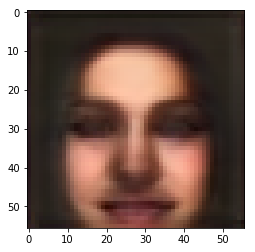

In [5]:
middle = K.zeros(shape=(1, input_shape)) 
i = Gen.predict(middle, steps=1)
im = (((i - i.min()) * 255) / (i.max() - i.min())).astype(np.uint8)
plt.imshow(im[0])

## Face 1

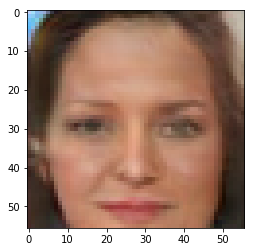

In [195]:
noise = K.random_normal_variable((1, input_shape), 0, 0.5)
i = Gen.predict(noise, steps=1)
im = (((i - i.min()) * 255) / (i.max() - i.min())).astype(np.uint8)
plt.imshow(im[0])

## Face 2

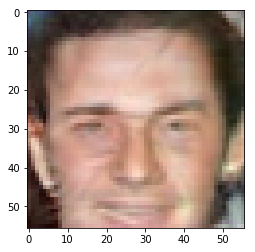

In [196]:
noise2 = K.random_normal_variable((1, input_shape), 0, 0.5)
i2 = Gen.predict(noise2, steps=1)
im2 = (((i2 - i2.min()) * 255) / (i2.max() - i2.min())).astype(np.uint8)
plt.imshow(im2[0])

## Face 1 + Face 2

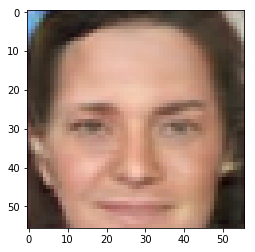

In [199]:
noise3 = (noise + noise2) / 2
i3 = Gen.predict(noise3, steps=1)
im3 = (((i3 - i3.min()) * 255) / (i3.max() - i3.min())).astype(np.uint8)
plt.imshow(im3[0])

## Scaling down the generator input noise

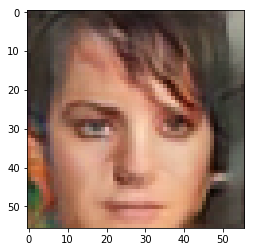

In [192]:
noise4 = K.random_normal_variable((1, input_shape), 0, 0.5)
i = Gen.predict(noise4, steps=1)
im = (((i - i.min()) * 255) / (i.max() - i.min())).astype(np.uint8)
plt.imshow(im[0])

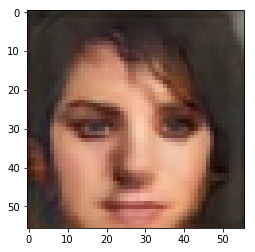

In [194]:
noiser = noise4 * 0.5
i = Gen.predict(noiser, steps=1)
im = (((i - i.min()) * 255) / (i.max() - i.min())).astype(np.uint8)
plt.imshow(im[0])

## GAN Reverse

In [22]:
def gan_reverse(i, steps = 50):
    z = np.random.normal(0, 0.5, size = [1, input_shape])
    x = K.placeholder()
    loss = K.sum(K.square(i - Gen.outputs[0]))
    grad = K.gradients(loss, Gen.inputs[0])[0]
    update_fn = K.function(Gen.inputs, [loss, grad])

    def eval_loss_and_grad(z, j):
        l, g = update_fn([z.reshape(1, input_shape), j])
        return l.astype('float64'), g.astype('float64')

    for step in range(steps):
        j = Gen.predict(z, steps=1)
        f = lambda x: eval_loss_and_grad(x, j)
        z, min_val, _ = fmin_l_bfgs_b(f, z, maxfun=20)
        z = z.reshape(1, input_shape)
        
        if step % 5 == 0:
            print("Step:", step)
    return z

Step: 0
Step: 5


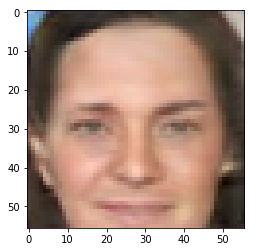

In [200]:
z = gan_reverse(i3, steps=6)
j = Gen.predict(z, steps=1)
j = (((j - j.min()) * 255) / (j.max() - j.min())).astype(np.uint8)
plt.imshow(j[0])

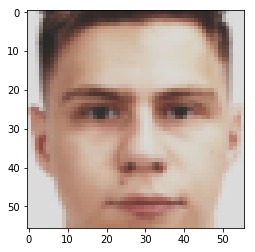

In [206]:
im_dir = glob(os.path.join('.', 'ja2.jpeg'))[0]
image1 = helper.get_image(im_dir, 'RGB', helper.preprocessing, width=56,  height=56, \
                          face_size=125, delta_i=-2, delta_j=-2)
plt.imshow(image1)

Step: 0
Step: 5
Step: 10
Step: 15
Step: 20
Step: 25
Step: 30


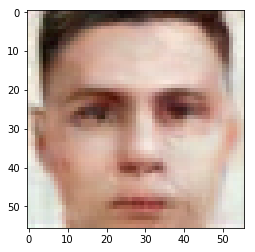

In [202]:
z1 = gan_reverse(image1 / 255 - 0.5, steps = 32)  
j1 = Gen.predict(z1, steps=1)
plt.imshow(helper.image_for_plot(j1[0]))

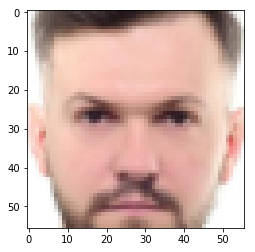

In [205]:
im_dir = glob(os.path.join('.', 'rno.jpeg'))[0]
image2 = helper.get_image(im_dir, 'RGB', helper.preprocessing, width=56, height=56, \
                         face_size=220, delta_i=-50, delta_j=0)
plt.imshow(image2)

Step: 0
Step: 5
Step: 10
Step: 15
Step: 20
Step: 25
Step: 30


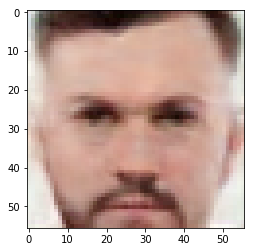

In [186]:
z2 = gan_reverse(image2 / 255 - 0.5, steps = 32)
j2 = Gen.predict(z2, steps=1)
plt.imshow(helper.image_for_plot(j2[0]))

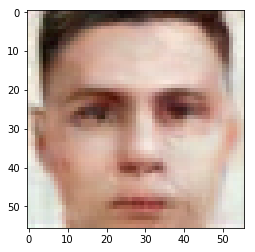

In [203]:
plt.imshow(helper.image_for_plot(j1[0]))

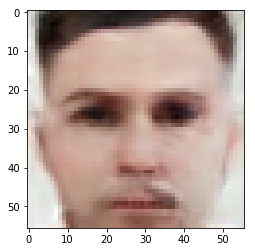

In [204]:
j3 = Gen.predict((z1 + z2) / 2, steps=1)
plt.imshow(helper.image_for_plot(j3[0]))